In [55]:
import spacy
nlp = spacy.load('en')
import nltk
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import pickle

import re

import nltk
import re
import string
from nltk.corpus import stopwords

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

import gensim
import pyLDAvis
from pyLDAvis import gensim as gensimvis
import spacy

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

import logging
from tqdm import tqdm
from pprint import pprint

[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [60]:
Dictionary

gensim.corpora.dictionary.Dictionary

In [41]:
sentences = pd.read_pickle('za_sentences.pkl')
sentences['cleaned'] = [w_tokenizer.tokenize(X.strip('][').replace(',','')) for X in sentences['cleaned']]

In [42]:
len(sentences)

2825355

In [43]:
sentences.head()

,review_index,sentence_index,sentence,cleaned
0,5,0,I'll be the first to admit that I was not exci...,"[admit, tavolta]"
1,5,1,"Being a food snob, when a group of friends su...","[food, snob, group, friend, dinner, menu]"
2,5,2,Im also not big on ordering pasta when I go out,"[ordering, pasta]"
3,5,3,"Alas, I was outnumbered",[]
4,5,4,Thank goodness! I ordered the sea bass special,"[goodness, sea, bass]"


In [44]:
reviews = pd.DataFrame(sentences.review_index.unique()).sample(20000)

In [45]:
reviews = reviews[0].tolist()


In [46]:
reviews[0:5]

[150687, 6124959, 3288893, 3590386, 5251736]

In [47]:
df = sentences[sentences['review_index'].isin(reviews)]

In [48]:
len(df)

141434

In [49]:
def get_topics_lda(tokenized_text, num_topics):
    id2word = gensim.corpora.Dictionary(tokenized_text)
    corpus = [id2word.doc2bow(t) for t in tokenized_text]
    lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=128,
                                           per_word_topics=True)
    return(lda_model)

In [50]:
lda_model = get_topics_lda(df.cleaned, 5)

In [51]:
lda_model.print_topics(num_words=20)

[(0,
  '0.063*"order" + 0.040*"salad" + 0.030*"menu" + 0.030*"staff" + 0.029*"minute" + 0.021*"pasta" + 0.019*"flavor" + 0.019*"chicken" + 0.018*"time" + 0.018*"dish" + 0.018*"server" + 0.015*"sandwich" + 0.012*"drink" + 0.012*"portion" + 0.011*"experience" + 0.011*"appetizer" + 0.010*"dessert" + 0.009*"fry" + 0.009*"table" + 0.008*"item"'),
 (1,
  '0.128*"place" + 0.049*"time" + 0.033*"restaurant" + 0.029*"love" + 0.026*"people" + 0.024*"food" + 0.022*"friend" + 0.022*"beer" + 0.021*"table" + 0.018*"family" + 0.014*"atmosphere" + 0.014*"area" + 0.011*"meal" + 0.010*"selection" + 0.010*"business" + 0.009*"lot" + 0.009*"choice" + 0.008*"check" + 0.008*"town" + 0.007*"group"'),
 (2,
  '0.105*"service" + 0.033*"food" + 0.028*"thing" + 0.028*"customer" + 0.028*"bar" + 0.019*"pie" + 0.017*"guy" + 0.016*"owner" + 0.015*"year" + 0.015*"option" + 0.014*"husband" + 0.012*"restaurant" + 0.012*"breakfast" + 0.012*"vega" + 0.011*"spot" + 0.010*"egg" + 0.010*"line" + 0.010*"phone" + 0.010*"door" + 

In [53]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return (model_list, coherence_values)

In [61]:
coherencemodel = CoherenceModel(model=lda_model, texts=df.cleaned, dictionary=Dictionary, coherence='c_v')

In [63]:
coherencemodel

In [81]:
coherence_values = []
model_list = []
id2word = gensim.corpora.Dictionary(df.cleaned)

In [82]:
limit=15; start=1; step=1;

for num_topics in range(start, limit, step):

    #model=LdaModel(corpus=[id2word.doc2bow(t) for t in df.cleaned], 
    #               id2word=Dictionary, 
    #               num_topics=5)
    model = get_topics_lda(df.cleaned, num_topics)
    model_list.append(model)

    coherencemodel = CoherenceModel(model=model, texts=df.cleaned, dictionary=id2word, coherence='c_v')

    coherence_values.append(coherencemodel.get_coherence())

coherence_values

[0.19594925005972924,
 0.11263885098272372,
 0.13882584075397553,
 0.22192219407642413,
 0.2372378530452902,
 0.23833297781762572,
 0.2535723894548901,
 0.24938702022014647,
 0.23269692668371592,
 0.22926538602296972,
 0.24429027841713882,
 0.25838640918230515,
 0.2561940514882575,
 0.27727996488363243]

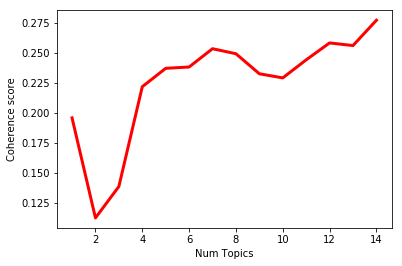

In [91]:
import matplotlib.pyplot as plt
limit=len(coherence_values); start=1; step=1;
x = range(start, limit+1, step)
plt.plot(x, coherence_values, color='red', linewidth=3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
#plt.legend(("coherence_values"), loc='best')
plt.savefig('coherence.png', dpi=100)
plt.show()

In [80]:
model_list

[]

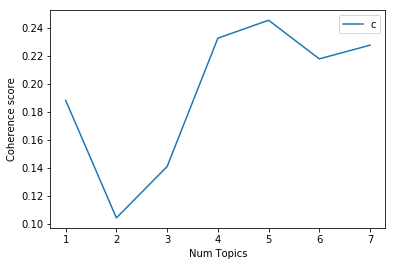

In [77]:
import matplotlib.pyplot as plt
limit=len(coherence_values); start=1; step=1;
x = range(start, limit+1, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()